# 1. 라이브러리

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 2. model 정의

## 2.1 변수 설정

In [5]:
latent_size = 64
hidden_size = 256
image_size = 28*28
batch_size = 64

# 2.2 generator

In [23]:
class Generator(nn.Module):
    def __init__(self):
        super (Generator,self).__init__()
        # 3 개의 fully connected layer 를 사용 --> ReLU , ReLU ,Tanh
        self.fc = nn.Sequential (
            # 1st FC : latent_size --> hidden_size
            nn.Linear(latent_size , hidden_size),
            nn.ReLU(),
            # 2nd FC : hidden_size --> hidden_size
            nn.Linear(hidden_size , hidden_size),
            nn.ReLU(),
            # 3rd FC : hidden_size --> image_size
            nn.Linear(hidden_size , image_size),
            nn.Tanh()
        )

    def forward(self , x):
        return self.fc(x)

## 2.3 discriminator

In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.fc = nn.Sequential(
            # 1st FC : image_size --> hidden_size , ReLU
            nn.Linear(image_size , hidden_size),
            nn.ReLU(),
            # 2nd FC : hidden_size --> hidden_size , ReLU
            nn.Linear(hidden_size , hidden_size),
            nn.ReLU(),
            # 3rd FC : hidden_size --> 1 (T/F) , Sigmoid
            nn.Linear(hidden_size , 1),
            nn.Sigmoid()
        )
    def forward(self , x):
        return self.fc(x)

# 3. data loading

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
mnist = MNIST(root='data/' , train=True , transform=transform , download=True)

data_loader = DataLoader (dataset=mnist,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2,
                          drop_last=True)

# 4. 초기 설정

In [29]:
n_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator().to(device)
D = Discriminator().to(device)

# loss 함수
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters() , lr=0.0002 , betas=(0.5,0.999))
g_optimizer = optim.Adam(G.parameters() , lr=0.0002 , betas=(0.5,0.999))

## 4.1 결과 출력 함수 : image를 (5x5)로 출력

In [36]:
def show_images (images , num_images=25 , size=(1,28,28)):
    print(images.shape)
    image_flat = images.detach().cpu().view(-1 , *size)
    image_grid = make_grid(image_flat[:num_images] , nrow=5)
    plt.imshow(image_grid.permute(1,2,0).squeeze())
    plt.show()

# 가져온 이미지에 대해
# 뒤에 25개를 가져와 5x5 크기로 짤라 화면에 그려준다.

# 5. 훈련

In [41]:
# n_epochs 만큼 수행

for epoch in range(n_epochs):
    # data_loader에서 batch_size 만큼 data 읽어오기
    for i , (images , _) in enumerate(data_loader): # label은 필요없음 , 생성이기 때문에
        # 1. Flatten the image : 이미지를 펴서 입력
        images = images.reshape(batch_size , -1).to(device) # batch_size 크기의 1차원 vector


        # 2. label 설정 : real --> 1 , fake --> 0
        real_labels = torch.ones(batch_size , 1).to(device)
        fake_labels = torch.zeros(batch_size , 1).to(device)


        # 3. descriminator 훈련
        # 3.1 real image loss 계산
        # discriminator 에 real image를 넣어서 결과를 출력
        output = D(images)
        # output 에 대한 loss 계산 : y_hat와 y의 차이 --> y_hat: output , y:read_labels
        d_loss_real = criterion(output , real_labels)

        # 3.2 fake image loss 계산
        # latent vector부터 생성
        z = torch.randn(batch_size , latent_size).to(device)
        # fake image를 생성
        fake_images = G(z)
        # discriminator 에 fake image를 넣어서 결과를 출력
        output =D(fake_images.detach()) # 단, 미분 안함
        # loss 구하기
        d_loss_fake = criterion(output , fake_labels)

        # 실제 loss
        d_loss = d_loss_real + d_loss_fake

        # 3.3 gradient --> gradient descent
        d_optimizer.zero_grad()
        d_loss.backward() # gradient
        d_optimizer.step() # gradient descent


        # 4. generator 훈련
        # 4.1 fake_image 를 생성해서 loss 계산
        z = torch.randn(batch_size , latent_size).to(device)
        # fake image를 생성
        fake_images = G(z)
        # discriminator 에 fake image를 넣어서 결과를 출력
        output =D(fake_images.detach()) # 단, 미분 안함
        g_loss = criterion(output , real_labels) # generator를 훈련을 위해서는 가짜를 진짜라고 훈련 그래서 real_labels를 넣어야됨

        # 4.1 gradient --> gradient descent
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    show_images(fake_images)
    show_images(images)

Output hidden; open in https://colab.research.google.com to view.

# 6. 실행

torch.Size([64, 784])


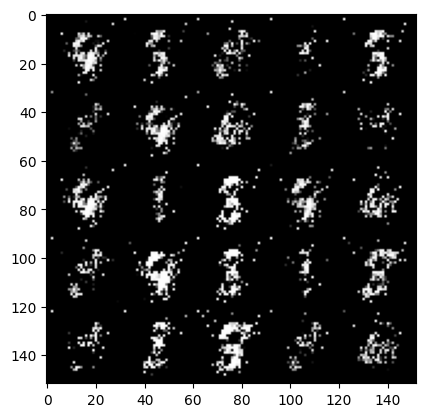

In [43]:
z = torch.randn(batch_size , latent_size).to(device)
fake_image = G(z)
show_images(fake_image)